In [90]:
!pip uninstall -y keras tensorflow
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers
!pip install transformers datasets torch
# !pip install --upgrade --force-reinstall pyarrow==16.1.0 --no-deps -q
!pip install -U transformers datasets accelerate

# import importlib, pyarrow
# importlib.reload(pyarrow)

from datasets import Dataset

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://download.pytorch.org/whl/cpu


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [92]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

# Import dataset from final_data_version.csv
df_balanced = pd.read_csv("../data/final_data_version.csv")

# Split my data
(X_train, X_train, y_train, y_test) = train_test_split(df_balanced.description, df_balanced.category, test_size=0.2, random_state=42)



In [94]:
# Run before training models

# Prepare data
le = LabelEncoder()
df_balanced['label'] = le.fit_transform(df_balanced['category'])

# Ensure correct column name
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['description'],
    df_balanced['label'],
    test_size=0.2,
    stratify=df_balanced['label'],
    random_state=42
)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset  = Dataset.from_dict({'text': X_test.tolist(),  'label': y_test.tolist()})

In [9]:
# Experiment using the BERT

# BERT Model
bert_model = "bert-base-uncased"

tokenizer_bert = AutoTokenizer.from_pretrained(bert_model)

def tokenize(batch):
    return tokenizer_bert(batch['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Load model
num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(bert_model, num_labels=num_labels)

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,                 # instead of evaluation_strategy
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100
)


# Trainer
trainer_bert = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer_bert
)

# Train
trainer_bert.train()


Map:   0%|          | 0/38592 [00:00<?, ? examples/s]

Map:   0%|          | 0/9648 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gs/rm1mjp5x5ybc93h8m4xwbfyr0000gn/T/ipykernel_13887/3274271668.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,2.100500
200,1.550700
300,1.247800
400,1.125500
500,1.108600
600,1.075300
700,1.003300
800,1.037800
900,0.928700
1000,0.983100


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=14472, training_loss=0.6442728026787045, metrics={'train_runtime': 7957.154, 'train_samples_per_second': 14.55, 'train_steps_per_second': 1.819, 'total_flos': 1.5232066794749952e+16, 'train_loss': 0.6442728026787045, 'epoch': 3.0})

In [10]:
# Evaluate Bert Model
preds_output_bert = trainer_bert.predict(test_dataset)
y_pred_bert = preds_output_bert.predictions.argmax(axis=1)
print(classification_report(y_test, y_pred_bert, target_names=le.classes_))

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                       precision    recall  f1-score   support

                  art       0.67      0.69      0.68      1000
     business/finance       0.84      0.81      0.82       923
       fantasy/horror       0.68      0.71      0.70      1000
                 food       0.83      0.80      0.82       891
              history       0.71      0.67      0.69      1000
religion/spirituality       0.72      0.77      0.75      1000
              romance       0.79      0.77      0.78      1000
              science       0.70      0.70      0.70      1000
      science fiction       0.73      0.72      0.72       966
             thriller       0.75      0.76      0.75       868

             accuracy                           0.74      9648
            macro avg       0.74      0.74      0.74      9648
         weighted avg       0.74      0.74      0.74      9648



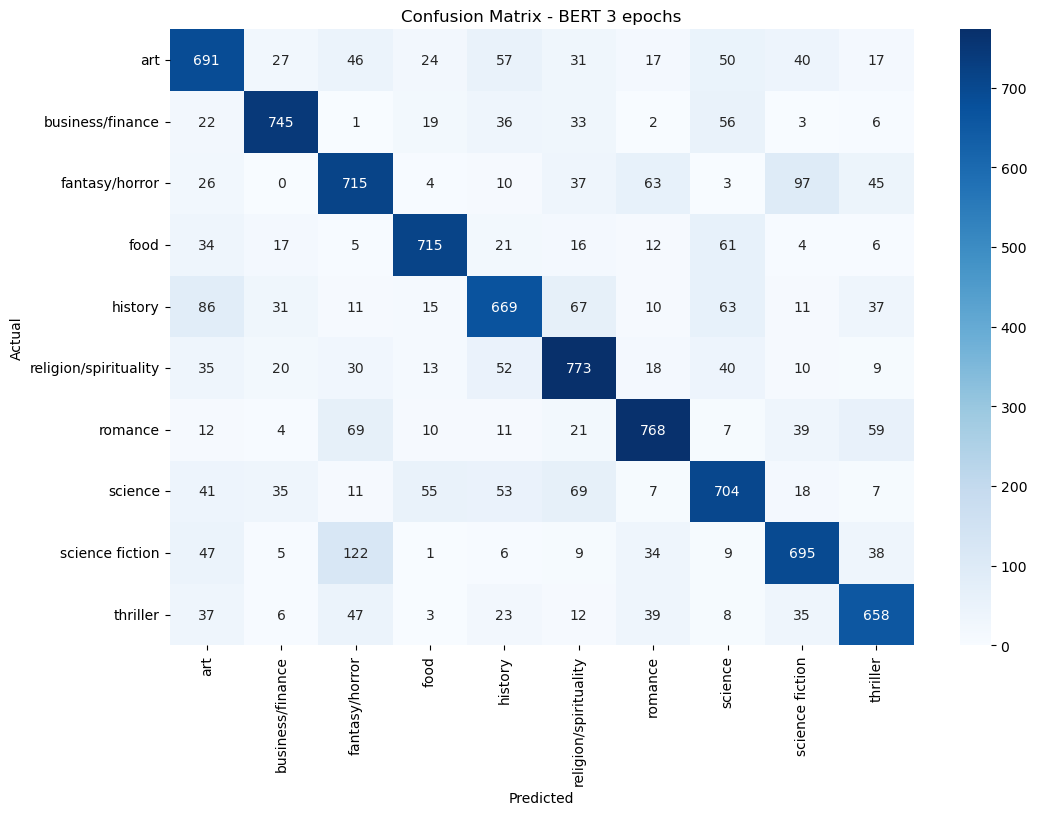

In [74]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_bert, labels=range(len(le.classes_)))

plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=le.classes_,  # These are category names
    yticklabels=le.classes_,  # Same here
    cmap='Blues'
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT 3 epochs')
plt.show()


In [96]:
# Experiment using the BERT - fine tuning initial call

# bert Model
bert_model_4_epochs = "bert-base-uncased"

tokenizer_bert_4_epochs = AutoTokenizer.from_pretrained(bert_model_4_epochs)

def tokenize(batch):
    return tokenizer_bert_4_epochs(batch['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Load model
num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(bert_model_4_epochs, num_labels=num_labels)

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,   
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,   
    metric_for_best_model="f1", 
    greater_is_better=True,
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1, 
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    report_to="none" 
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }


# Trainer
trainer_bert_4_epochs = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer_bert_4_epochs,
    compute_metrics=compute_metrics 
)

# Train
trainer_bert_4_epochs.train()


Map:   0%|          | 0/38592 [00:00<?, ? examples/s]

Map:   0%|          | 0/9648 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gs/rm1mjp5x5ybc93h8m4xwbfyr0000gn/T/ipykernel_13887/1370488467.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert_4_epochs = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.841900,0.872451,0.714863,0.722703,0.714863,0.714925
2,0.688700,0.857326,0.732483,0.738608,0.732483,0.733932
3,0.453600,1.027509,0.732172,0.736407,0.732172,0.733088
4,0.199400,1.263660,0.730307,0.731689,0.730307,0.730808


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=19296, training_loss=0.6131308791451588, metrics={'train_runtime': 12104.7596, 'train_samples_per_second': 12.753, 'train_steps_per_second': 1.594, 'total_flos': 2.0309422392999936e+16, 'train_loss': 0.6131308791451588, 'epoch': 4.0})

In [97]:
# Evaluate Bert Model
preds_output_bert_4_epochs = trainer_bert_4_epochs.predict(test_dataset)
y_pred_bert_4_epochs = preds_output_bert_4_epochs.predictions.argmax(axis=1)
print(classification_report(y_test, y_pred_bert_4_epochs, target_names=le.classes_))

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                       precision    recall  f1-score   support

                  art       0.63      0.71      0.67      1000
     business/finance       0.85      0.77      0.81       923
       fantasy/horror       0.66      0.72      0.69      1000
                 food       0.83      0.80      0.81       891
              history       0.64      0.73      0.68      1000
religion/spirituality       0.72      0.77      0.74      1000
              romance       0.83      0.73      0.78      1000
              science       0.75      0.66      0.70      1000
      science fiction       0.74      0.72      0.73       966
             thriller       0.75      0.73      0.74       868

             accuracy                           0.73      9648
            macro avg       0.74      0.73      0.74      9648
         weighted avg       0.74      0.73      0.73      9648



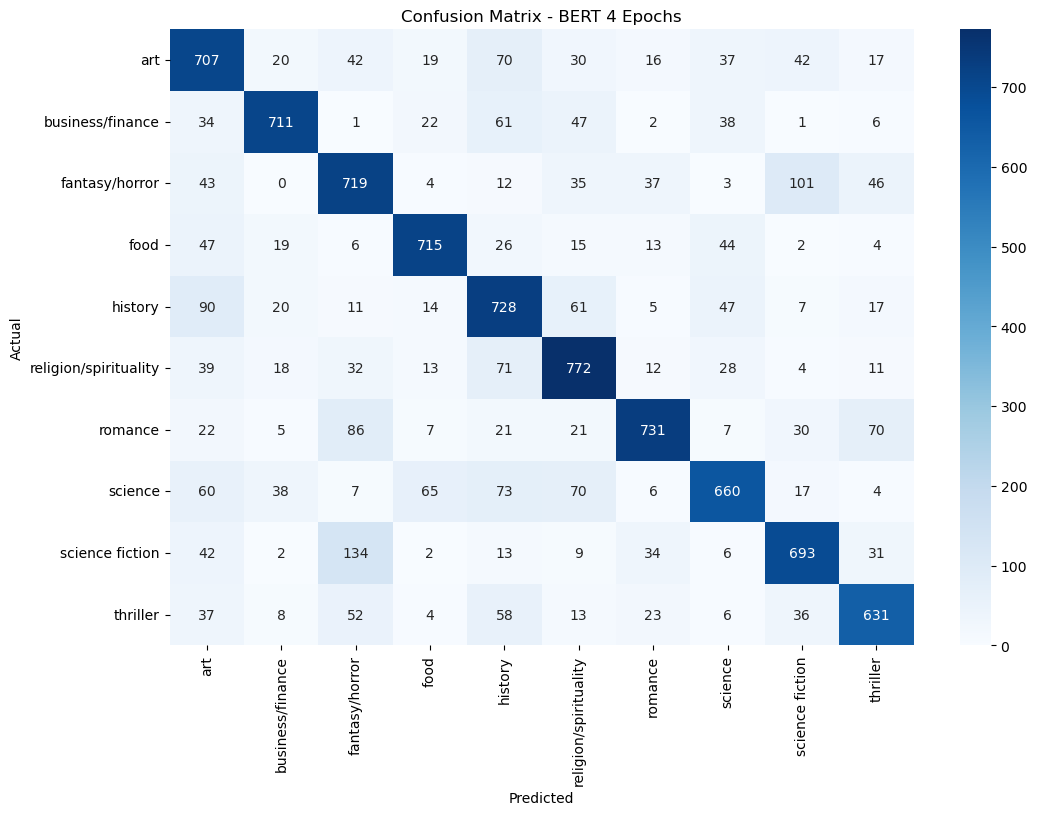

In [98]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_bert_4_epochs, labels=range(len(le.classes_)))

plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=le.classes_,  # These are category names
    yticklabels=le.classes_,  # Same here
    cmap='Blues'
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT 4 Epochs')
plt.show()


In [51]:
# Experiment using the BERT - fine tuning initial call

# BERT Model
bert_model_5_epochs = "bert-base-uncased"

tokenizer_bert_5_epochs = AutoTokenizer.from_pretrained(bert_model_5_epochs)

def tokenize(batch):
    return tokenizer_bert_5_epochs(batch['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Load model
num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(bert_model_4_epochs, num_labels=num_labels)

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,   
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,   
    metric_for_best_model="f1", 
    greater_is_better=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1, 
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    report_to="none" 
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }


# Trainer
trainer_bert_5_epochs = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer_bert_5_epochs,
    compute_metrics=compute_metrics 
)

# Train
trainer_bert_5_epochs.train()


Map:   0%|          | 0/38592 [00:00<?, ? examples/s]

Map:   0%|          | 0/9648 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gs/rm1mjp5x5ybc93h8m4xwbfyr0000gn/T/ipykernel_13887/1726257786.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert_5_epochs = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.846100,0.888996,0.715796,0.723652,0.715796,0.714865
2,0.709100,0.853451,0.735593,0.741026,0.735593,0.736922
3,0.475700,1.008474,0.732483,0.737892,0.732483,0.733191
4,0.207200,1.363693,0.731447,0.732667,0.731447,0.731499
5,0.208900,1.560025,0.729478,0.730263,0.729478,0.729653


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=24120, training_loss=0.5384492676946061, metrics={'train_runtime': 14022.2675, 'train_samples_per_second': 13.761, 'train_steps_per_second': 1.72, 'total_flos': 2.538677799124992e+16, 'train_loss': 0.5384492676946061, 'epoch': 5.0})

In [52]:
# Evaluate Bert Model
preds_output_bert_5_epochs = trainer_bert_5_epochs.predict(test_dataset)
y_pred_bert_5_epochs = preds_output_bert_5_epochs.predictions.argmax(axis=1)
print(classification_report(y_test, y_pred_bert_5_epochs, target_names=le.classes_))

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                       precision    recall  f1-score   support

                  art       0.65      0.69      0.67      1000
     business/finance       0.86      0.76      0.81       923
       fantasy/horror       0.66      0.73      0.69      1000
                 food       0.81      0.81      0.81       891
              history       0.65      0.73      0.69      1000
religion/spirituality       0.73      0.77      0.75      1000
              romance       0.83      0.73      0.78      1000
              science       0.74      0.68      0.71      1000
      science fiction       0.76      0.72      0.74       966
             thriller       0.74      0.73      0.73       868

             accuracy                           0.74      9648
            macro avg       0.74      0.74      0.74      9648
         weighted avg       0.74      0.74      0.74      9648



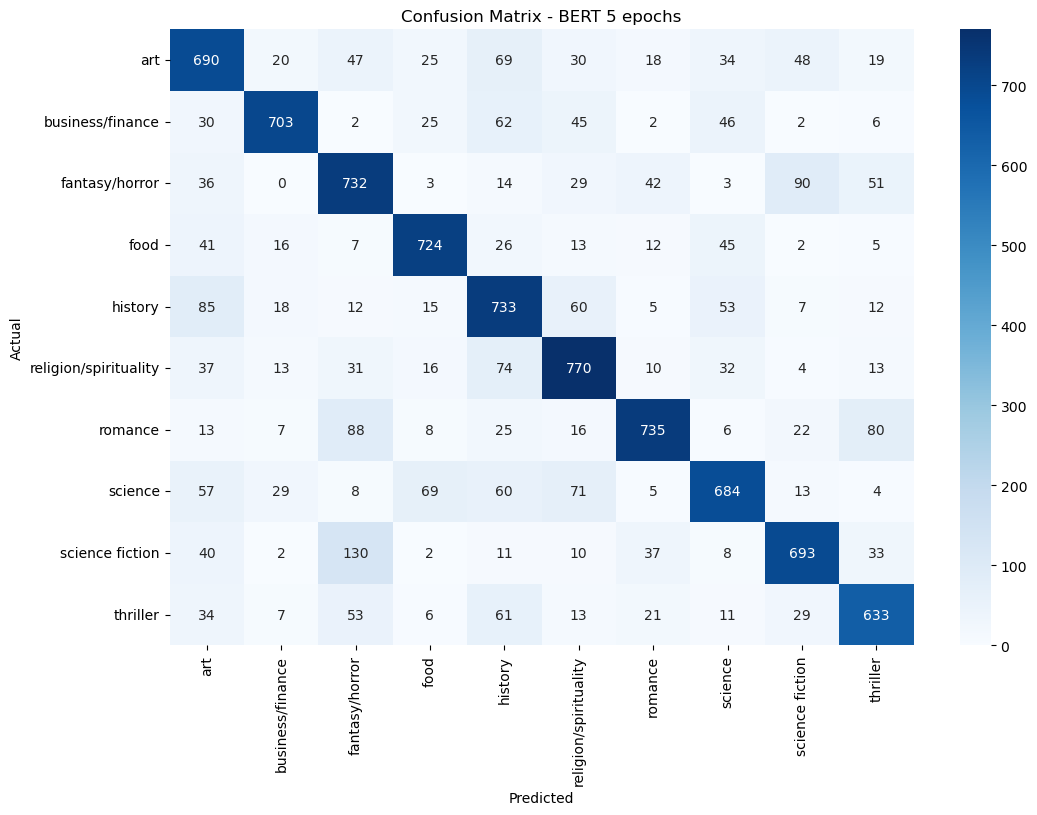

In [81]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_bert_5_epochs, labels=range(len(le.classes_)))
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_,
            yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT 5 epochs')
plt.show()

In [53]:
# Experiment using the roBERTa - fine tuning initial call

# roberta Model
roberta_model_4_epochs = "roberta-base"

tokenizer_robert_4_epochs = AutoTokenizer.from_pretrained(roberta_model_4_epochs)

def tokenize(batch):
    return tokenizer_robert_4_epochs(batch['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Load model
num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(roberta_model_4_epochs, num_labels=num_labels)

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,   
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,   
    metric_for_best_model="f1", 
    greater_is_better=True,
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1, 
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    report_to="none" 
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }


# Trainer
trainer_robert_4_epochs = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer_robert_4_epochs,
    compute_metrics=compute_metrics 
)

# Train
trainer_robert_4_epochs.train()


Map:   0%|          | 0/38592 [00:00<?, ? examples/s]

Map:   0%|          | 0/9648 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gs/rm1mjp5x5ybc93h8m4xwbfyr0000gn/T/ipykernel_13887/2482755446.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_robert_4_epochs = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.889200,0.873174,0.713308,0.717416,0.713308,0.712884
2,0.764400,0.905117,0.720357,0.732148,0.720357,0.722092
3,0.566900,0.921354,0.735697,0.738990,0.735697,0.736242
4,0.377600,1.052941,0.736629,0.737970,0.736629,0.736854


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=19296, training_loss=0.7094653329841335, metrics={'train_runtime': 15317.2363, 'train_samples_per_second': 10.078, 'train_steps_per_second': 1.26, 'total_flos': 2.0309422392999936e+16, 'train_loss': 0.7094653329841335, 'epoch': 4.0})

In [54]:
# Evaluate Bert Model
preds_output_roberta_4_epochs = trainer_robert_4_epochs.predict(test_dataset)
y_pred_roberta_4_epochs = preds_output_roberta_4_epochs.predictions.argmax(axis=1)
print(classification_report(y_test, y_pred_roberta_4_epochs, target_names=le.classes_))

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                       precision    recall  f1-score   support

                  art       0.68      0.71      0.69      1000
     business/finance       0.81      0.82      0.82       923
       fantasy/horror       0.66      0.71      0.69      1000
                 food       0.84      0.79      0.81       891
              history       0.70      0.67      0.69      1000
religion/spirituality       0.75      0.74      0.75      1000
              romance       0.77      0.76      0.77      1000
              science       0.73      0.71      0.72      1000
      science fiction       0.74      0.68      0.71       966
             thriller       0.72      0.76      0.74       868

             accuracy                           0.74      9648
            macro avg       0.74      0.74      0.74      9648
         weighted avg       0.74      0.74      0.74      9648



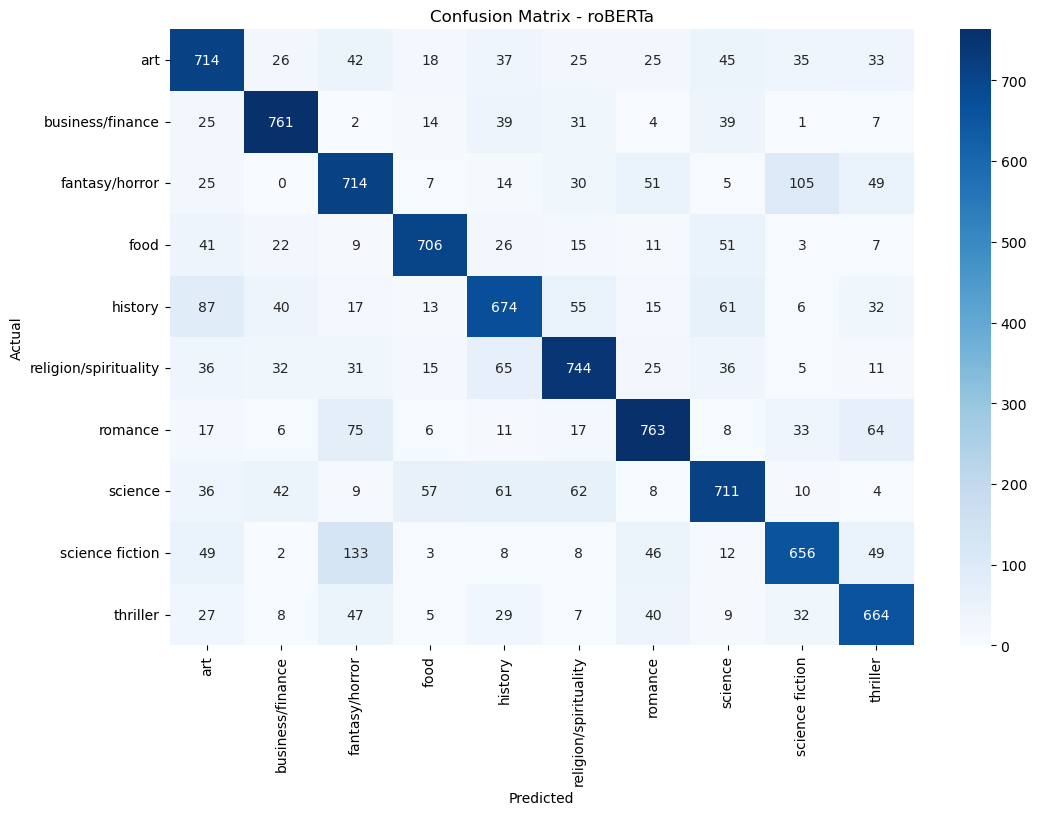

In [82]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_roberta_4_epochs, labels=range(len(le.classes_)))
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_,
            yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - roBERTa')
plt.show()

In [58]:
# Experiment using the roBERTa - fine tuning initial call

# roberta Model
roberta_model_2_epochs = "roberta-base"

tokenizer_robert_2_epochs = AutoTokenizer.from_pretrained(roberta_model_2_epochs)

def tokenize(batch):
    return tokenizer_robert_4_epochs(batch['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
# Load model
num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(roberta_model_2_epochs, num_labels=num_labels)

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,   
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,   
    metric_for_best_model="f1", 
    greater_is_better=True,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1, 
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    report_to="none" 
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }


# Trainer
trainer_robert_2_epochs = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer_robert_2_epochs,
    compute_metrics=compute_metrics 
)

# Train
trainer_robert_2_epochs.train()


Map:   0%|          | 0/38592 [00:00<?, ? examples/s]

Map:   0%|          | 0/9648 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gs/rm1mjp5x5ybc93h8m4xwbfyr0000gn/T/ipykernel_13887/3596616878.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_robert_2_epochs = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.877000,0.839945,0.721289,0.726351,0.721289,0.721853
2,0.706000,0.819553,0.738910,0.740868,0.738910,0.739604


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=9648, training_loss=0.8703529520414361, metrics={'train_runtime': 5720.2327, 'train_samples_per_second': 13.493, 'train_steps_per_second': 1.687, 'total_flos': 1.0154711196499968e+16, 'train_loss': 0.8703529520414361, 'epoch': 2.0})

In [59]:
# Evaluate Bert Model
preds_output_roberta_2_epochs = trainer_robert_2_epochs.predict(test_dataset)
y_pred_roberta_2_epochs = preds_output_roberta_2_epochs.predictions.argmax(axis=1)
print(classification_report(y_test, y_pred_roberta_2_epochs, target_names=le.classes_))

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                       precision    recall  f1-score   support

                  art       0.67      0.70      0.68      1000
     business/finance       0.85      0.80      0.83       923
       fantasy/horror       0.67      0.69      0.68      1000
                 food       0.86      0.80      0.83       891
              history       0.68      0.72      0.70      1000
religion/spirituality       0.74      0.76      0.75      1000
              romance       0.77      0.79      0.78      1000
              science       0.72      0.70      0.71      1000
      science fiction       0.72      0.70      0.71       966
             thriller       0.74      0.75      0.74       868

             accuracy                           0.74      9648
            macro avg       0.74      0.74      0.74      9648
         weighted avg       0.74      0.74      0.74      9648



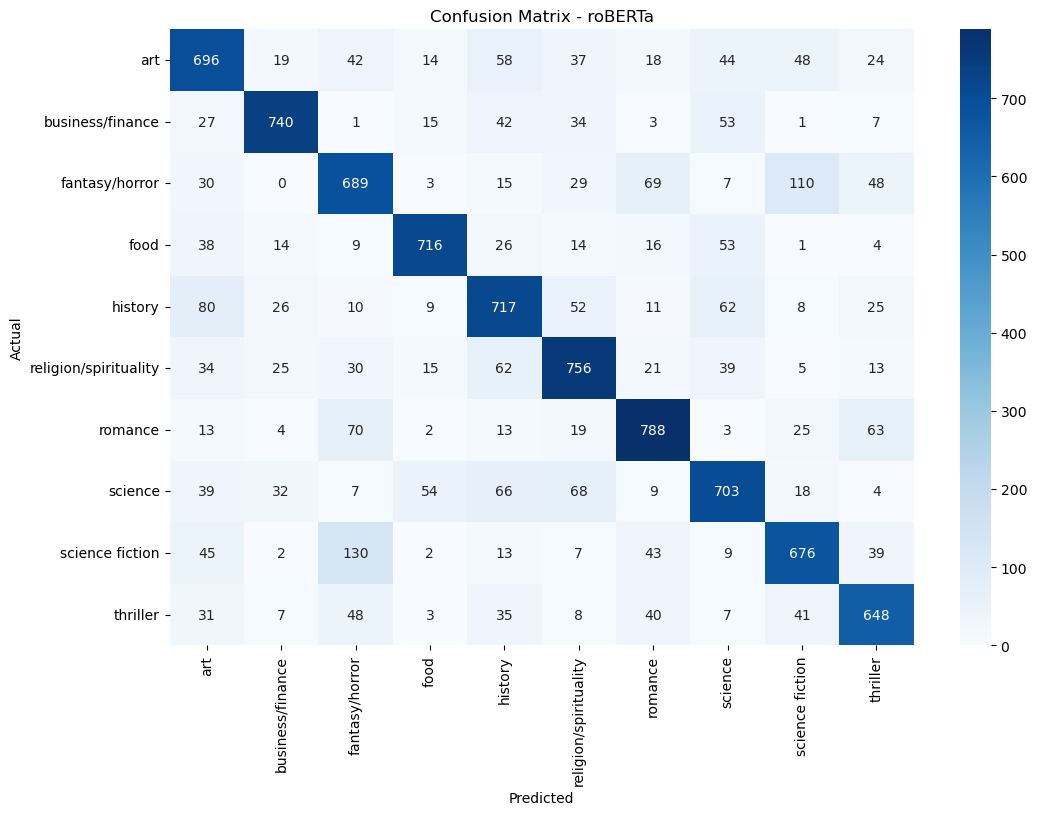

In [83]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred_roberta_2_epochs, labels=range(len(le.classes_)))
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_,
            yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - roBERTa')
plt.show()

# Fine Tuning Analysis

From the following tuning, it is apparent that the two that should be considered is the BERT model with 3 epochs and the roBERTa model with 2 epochs. The reason for this is that both contain the greatest separation of the different categories along with both being a reasonable/lesser time to complete the training. This must be taken into account for overall usage. 

## Clustering
Of the two RoBERTa performs better by only slight measure. There is a slightly more distinct separation of classes overall when looking at all the categories. The consistency is also greater with the roBERTa model. The following categories have fewer misclassifications: food, romance, and religion/spirituality. Fantasy/horror  and scifi still remain as the most problematic fields in both models. Despite it being slightly less separated in the BERT model over the roBERTa one, the roBERTa one still shows the greater performance between the two. 

## Performace
An interesting thing to note between the two models is that the BERT model performed better in narrative-led/ story-driven categories such as Thriller, SciFi, Art(which included multiple story-driven forms like comics) and Fantasy/Horror. The roBERTA modelhad an edge t more factual driven categories such as Business/Finance, Food, History, and Science. So the BERT model has an edge on more narrative/stylistic synopsis while BERT has an edge of fact base synopsis. 

The F1 and presicion scores, however do lean in roBERTa's favor as they are overall more consistent.

## Time
The roBERTa model took 1:35:18 and the BERT model took 2:12:35. roBERTa was faster by nearly a fourth of the time it took the BERT model which is rather a significant difference. 


## Conclusion
Based on the above areas, nearly every category is negliable in terms of performace and clustering. The trade-offs between the models are small. Therefore, the default will go to the model that performed at the least amount of time. roBERTa at 2 epochs for an hour and a half is a significant improvement over the BERT model at 3 epochs. After fine tuning, the roBERTa model at 2 epochs is the best model to use for the final model in my capstone.